In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
# to build a model that can read text from lips, you need to load two datasets
# - with video, with people's lips
# - with text spoken by lips on each video

import gdown

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'

gdown.download(url, output, quiet=False)
# Downloads the file at the specified URL and saves it as data.zip.


#Extracts all files from data.zip into the current working directory.
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:10<00:00, 41.4MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [3]:
def load_video(path:str) -> List[float]:
# we define a function load_video that takes one argument path of type str
# (a string representing the path to the video file). -> List[float] indicates that
# that the function should return an object of type List[float].

# -> List[float]: This part indicates the return type of the function.
# List[float] means that the function returns a list of floating point numbers (floats).
# In this context, it is possible for a function to load a video and return a list of numbers (e.g.
# pixel values) in the video.


# -> in Python is used to annotate the return types of a function.
# This means that the -> is followed by the expected data type that the function should return.


  cap = cv2.VideoCapture(path)


# put all frames from the video into one list
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()



# This function from the TensorFlow library converts an RGB image to grayscale
    frame = tf.image.rgb_to_grayscale(frame)

    frames.append(frame[190:236, 80:220, :])
 # frame[190:236, 80:220, :] means we select a rectangular area of ​​the image,
    # which covers rows 190 to 235 and columns 80 to 219 (inclusive) for all color channels
    # - to outline the mouth area.



# cap.release() is a method of the cv2.VideoCapture object that is used to release resources,
# related to video stream capture. When you are finished working with an object
  cap.release()


# video frame normalization

  mean = tf.math.reduce_mean(frames)
# Calculates the average of all elements in the frames tensor.

# Calculates the standard deviation of all elements in the frames tensor.
# Before calculating the standard deviation, frames is cast to type tf.float32.
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))


# Centering and scaling (standardization) of frames is carried out.
  # The average value mean is subtracted to each element of the frames tensor,
  # and then divide the result by the standard deviation std.
  return tf.cast((frames - mean), tf.float32) / std


In [4]:
# characters we expect to receive as a response
dictio_nary = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [5]:
# We create functions for converting text into numbers and vice versa

char_to_num = tf.keras.layers.StringLookup(vocabulary = dictio_nary, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary =char_to_num.get_vocabulary(), oov_token = "", invert = True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [6]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [7]:

# load text files that correspond to video with lip movements
# folder name with text - alignments

def load_alignments(path:str) -> List[str]:
    with open(path, "r") as f:

# used to read all lines from the file specified by the file object f,
# and saving them as a list of strings. Each line of the file becomes an element of the list.
        lines = f.readlines()
    tokens = []

  #split the list of lines into line objects
    for line in lines:
        line = line.split()
      # sil - silance, the moment when there is silence in the video - we do not add these moments to the list of tokens
        if line[2] != "sil":
            tokens = [*tokens,' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1)))[1:]

In [8]:
# all data uploading

def load_data(path: str):


# decodes a byte string into a regular one
  path = bytes.decode(path.numpy())

  file_name = path.split("/")[-1].split('.')[0]
# This line splits the string path into parts using the delimiter \
# (backslash) and selects the last part, assuming it is a filename.
# Then it splits the filename dotwise and selects the first part (without the file extension),
# storing the result in the file_name variable.



# path to video, 'data', 's1', - folders where the files are located
  video_path = os.path.join('data', 's1', f"{file_name}.mpg")

 # path to text files, 'data', "alignments", 's1' - folders where the files are located
  alignment_path = os.path.join('data', "alignments", 's1', f"{file_name}.align")

  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

In [9]:
test_path = './data/s1/bbal6n.mpg'

tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

# test_path = '.\\data\\s1\\bba16n.mpg': Creates a test_path string representing the path to the video file
# "bba16n.mpg" in the "data/s1/" subfolder.

# tf.convert_to_tensor(test_path).numpy().decode('utf-8'):
# Converts the string test_path to a TensorFlow tensor and then returns it as a NumPy array.
# Next, using decode('utf-8'), the byte string is decoded into a string using UTF-8 encoding.

# as a result we get the name of the video file - without extension - "bba16n"

'bbal6n'

In [10]:
# The code load_data(tf.convert_to_tensor(test_path)) will return a tuple containing two elements: the first element -
# this is a tensor representing video frames and the second element is a tensor representing text information
# (in this case, text with lip movements).
# Each of these tensors will have an appropriate shape and contain data in numeric format.
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4603736 ],
          [ 1.4603736 ],
          [ 1.4209042 ],
          ...,
          [ 0.15787823],
          [ 0.19734779],
          [ 0.07893912]],
 
         [[ 1.4603736 ],
          [ 1.4603736 ],
          [ 1.4209042 ],
          ...,
          [ 0.15787823],
          [ 0.07893912],
          [ 0.03946956]],
 
         [[ 1.4209042 ],
          [ 1.4209042 ],
          [ 1.3814346 ],
          ...,
          [ 0.07893912],
          [ 0.07893912],
          [ 0.07893912]],
 
         ...,
 
         [[ 0.9472694 ],
          [ 0.9472694 ],
          [ 0.9472694 ],
          ...,
          [ 9.946329  ],
          [ 9.86739   ],
          [ 9.86739   ]],
 
         [[ 0.9472694 ],
          [ 0.9472694 ],
          [ 0.9472694 ],
          ...,
          [ 9.906859  ],
          [ 9.86739   ],
          [ 9.86739   ]],
 
         [[ 0.9472694 ],
          [ 0.9472694 ],
          [ 0.9472694 ],
          

In [11]:
# we pass both tensors into variables
frames, alignments = load_data(tf.convert_to_tensor(test_path))


In [12]:
# and output
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603736 ],
         [ 1.4603736 ],
         [ 1.4209042 ],
         ...,
         [ 0.15787823],
         [ 0.19734779],
         [ 0.07893912]],

        [[ 1.4603736 ],
         [ 1.4603736 ],
         [ 1.4209042 ],
         ...,
         [ 0.15787823],
         [ 0.07893912],
         [ 0.03946956]],

        [[ 1.4209042 ],
         [ 1.4209042 ],
         [ 1.3814346 ],
         ...,
         [ 0.07893912],
         [ 0.07893912],
         [ 0.07893912]],

        ...,

        [[ 0.9472694 ],
         [ 0.9472694 ],
         [ 0.9472694 ],
         ...,
         [ 9.946329  ],
         [ 9.86739   ],
         [ 9.86739   ]],

        [[ 0.9472694 ],
         [ 0.9472694 ],
         [ 0.9472694 ],
         ...,
         [ 9.906859  ],
         [ 9.86739   ],
         [ 9.86739   ]],

        [[ 0.9472694 ],
         [ 0.9472694 ],
         [ 0.9472694 ],
         ...,
         [ 9.906859  ],
         [ 9.86739

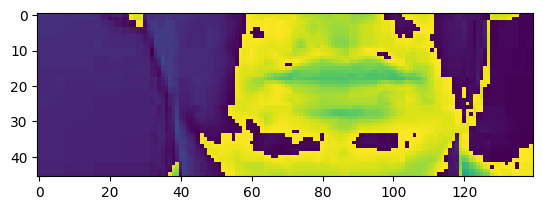

In [13]:
# first frame output
plt.imshow(frames[0])

In [14]:
# alignments array output
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [15]:
# The code converts numeric representations of characters into text information and outputs it as a list of strings.
# each object in alignments corresponds to an object in frames
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [16]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [17]:
# This code creates a mappable_function,
# which uses tf.py_function to convert the load_data(path) function call into a TensorFlow operation.
# In this case, load_data returns two tensors: one with video frames and the other
# with text information about lip movements.



def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
# tf.py_function is used to
# to allow arbitrary Python functions to be used inside a TensorFlow graph.
# This is especially useful when you need to include operations in your graph
# which are not part of standard TensorFlow operations.

# The mappable_function function returns the result of tf.py_function,
# which in this case is a tuple of two tensors:
# tf.float32 for video frames and tf.int64 for text information about lip movements.

    return result

In [18]:
# create a data pipeline

# pipeline - sequences of data processing from their initial state (for example,
# their collection or loading) to the final state (for example, use in a machine learning model).

# In the context of programming and data analysis, a data pipeline is a series of steps or stages,
# in which data is subjected to various operations: loading,
# preprocessing, cleaning, conversion, etc.
# The purpose of such a pipeline is to prepare data for analysis, model training, or other tasks.
# создаем датасет для видео-файлов

data = tf.data.Dataset.list_files('./data/s1/*.mpg')

# data shuffling
data = data.shuffle(500, reshuffle_each_iteration=False)
# If shuffle_each_iteration is set to False,
# then the data will be mixed only before training begins
# (by the first epoch), and they will be used in the same order in each subsequent epoch.




# When you apply a map to your dataset using mappable_function it means
# that mappable_function will be called for each element of your dataset.

# mappable_function returns the result, which is added to the new dataset.
# In your case, mappable_function uses tf.py_function to apply the load_data function
# to each element of the dataset, and the result consists of two tensors:
# tensor of video frames and tensor of text data with lip movements.


# So after executing this line of code, data becomes a dataset,
# containing pairs of tensors (video frames, text data) for each video file in your source dataset.


data = data.map(mappable_function)

data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# padded_batch is used to pack data into batches and add padding,
# to make them the same length in each batch. In this case, the batch size is set to 2.
# padded_shapes указывает, какие измерения следует заполнять.


# [75, None, None, None] means the first dimension (in time) will be filled to size 75,
# and the remaining dimensions will be filled in automatically

#[40] specifies that the second dimension (text data) will be padded to size 40.

data = data.prefetch(tf.data.AUTOTUNE)
# prefetch is used to prepare the next batch of data while processing the current batch.
# tf.data.AUTOTUNE automatically selects the appropriate amount of data to preload,
# based on available resources.

train = data.take(450)
# line creates a new train dataset that contains the first 450 elements from the original data dataset.
# So train will be used to train the model on the first 450 data items.

# line creates a new test dataset that contains all the elements from the original data dataset, starting with 451 elements and ending.
# So test will be used to test the model on the remaining data (from 451 elements onwards).
test = data.skip(450)

In [19]:
# содержимое тензора data разбиваем на две переменные
frames, alignments = data.as_numpy_iterator().next()

In [20]:
print(alignments)
# выводит количество соответствующих текстовых данных.

len(frames)
# выводит количество видеофайлов в вашем батче, и

[[16 12  1  3  5 39 23  8  9 20  5 39  9 14 39 10 39  6 15 21 18 39 16 12
   5  1 19  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  9 14 39  7 18  5  5 14 39  9 14 39  1 39 20  8 18  5  5 39 19 15 15
  14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


2

In [21]:
test = data.as_numpy_iterator()

In [22]:
value = test.next();
value[0]

array([[[[[ 1.3879623 ],
          [ 1.3879623 ],
          [ 1.3086503 ],
          ...,
          [10.072641  ],
          [10.112297  ],
          [10.112297  ]],

         [[ 1.3879623 ],
          [ 1.3879623 ],
          [ 1.3086503 ],
          ...,
          [10.112297  ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.3086503 ],
          [ 1.3086503 ],
          [ 1.3086503 ],
          ...,
          [10.112297  ],
          [10.112297  ],
          [10.112297  ]],

         ...,

         [[ 0.9517456 ],
          [ 0.9517456 ],
          [ 0.9120896 ],
          ...,
          [ 9.874361  ],
          [ 9.874361  ],
          [ 9.874361  ]],

         [[ 0.9517456 ],
          [ 0.9517456 ],
          [ 0.9120896 ],
          ...,
          [ 9.834705  ],
          [ 9.834705  ],
          [ 9.834705  ]],

         [[ 0.9517456 ],
          [ 0.9517456 ],
          [ 0.9120896 ],
          ...,
          [ 9.834705  ],
          [ 9.834705  ],
          

In [23]:
# gif animation object creating
fv = (value[0][0].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)


# The basis for creating GIF animation in this code is an array of frames represented in the fv variable.
# This array is created from the second element (value[0][1]), which probably contains video frames.

# in value[0][1] - 0 - the first part of the value variable, which contains video files (the second contains text data)
#1 - means the second video in the queue, which turns into a GIF



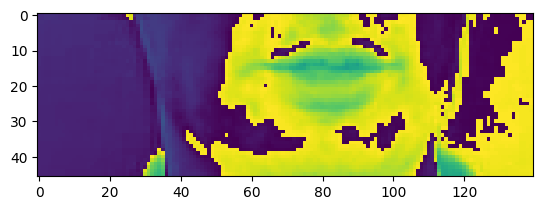

In [24]:
# the first index is part of the variable value (video files) - in this case the index is 0, which means the part is the first
# the second index is the serial number of the video - in this case the index is 0, which means the video is the first
# third inlex - video frame

plt.imshow(value[0][0][35])

In [25]:
# iterate through each word in value[1] - an array with text data
# second index means the number of the text file

# if we re-run the code starting from value = test.next();
# value[0], then a new phrase will be displayed each time, since the data is mixed
tf.strings.reduce_join([num_to_char(word) for word in value[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red by o five again'>

In [26]:
# NN building
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape
# it returns the shape of the first element in the data batch.
# In this case the shape is (75, 46, 140, 1)

(75, 46, 140, 1)

In [28]:
model = Sequential()
# input_shape -  data size
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
# 3D convolutional layer with 128 filters, 3x3x3 kernel and input shape (75, 46, 140, 1).
# Padding='same' means adding zero pixels to maintain dimension.



model.add(Activation('relu'))


# max subsampling layer for dimensionality reduction.
model.add(MaxPool3D((1, 2, 2)))


# the same with a different number of filters
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))
# layer that applies Flatten() to all time dimensions.
# It is needed to pass the output of convolutional layers to subsequent recurrent layers.



model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))
# bidirectional LSTM layer with 128 neurons in each direction,
# initialized by an orthogonal method, and returning sequences.

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
# fully connected layer with the number of neurons equal to the size of the dictionary + 1,
# and the softmax activation function - each letter in char_to_num is assigned a separate value

In [29]:
x = model.summary()
x

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [31]:
# prediction initialization
output = model.predict(value[0])

1/1 [==============================] - 14s 14s/step


In [32]:
# each value of output tensor is presented as (75, 41)
# where 75 is the number of frames in each video

#41 - meanings for the dictionary with letters


output[0].shape

(75, 41)

In [33]:
# prediction output
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(output[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'fffsssssssssshhhhhhhhhhhhhhhhhhhhshhhhhhhhhhhhhhhhhhhhhffffffhhhhhhhhhddddh'>

In [35]:
# input shape output
model.input_shape


(None, 75, 46, 140, 1)

In [36]:
# output shape output
model.output_shape

(None, 75, 41)

In [37]:
# sets the rule for changing the learning rate depending on the training epoch number.
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [38]:
# define the STS loss function

# code defines a custom loss function for Connectionist Temporal Classification (CTC)
# in tasks of recognizing speech or other sequences.
# CTC is an unsupervised learning method that allows a model to learn
# alignment between input and target labels,
# without requiring an exact match between them.



# CTCLoss takes two arguments: y_true and y_pred. y_true represents the true labels,
# and y_pred are model-predicted logits (non-activated model outputs)
# for each time step.
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

   # Creates the input_length and label_length tensors,
    # which contain the lengths of the predictions and true labels, respectively.



# In the context of the CTC (Connectionist Temporal Classification) task, "true labels"
# usually refers to a sequence of characters (or tokens)
# which you want to extract from the input sequence.
# For example, in speech recognition tasks,
# true labels can be a sequence of phonemes or letters,
# that need to be recognized in the audio recording.

    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')

# input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64'):
# Here we create a tensor input_length, which represents the length of the input
# model sequences. tf.shape(y_pred) returns the dimension of the y_pred tensor,
# and [1] extracts the number of time steps (or frames) in the model's predictions.
# This value is then cast to int64 using tf.cast.
# In the context of CTC, this is the number of time steps in the model's predictions.


    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
# : Here we create a tensor that contains the input_length values,
# repeated batch_len times along the first dimension.
# This can be useful in the context of processing batches of data.
# For example, if we have batch_len of data batches,
# and in each batch input_length has different values, these lines of code will create a tensor,
# in which each input_length value will be repeated batch_len times.

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

# y_true: This is a ground truth tensor that contains the indices of the characters in the ground truth sequence. The form of this tensor is usually (batch_size, max_label_length),
# where max_label_length is the maximum length of the label in the batch.

# y_pred: This is a tensor of predicted probabilities for each symbol at each time step. The form of this tensor is usually (batch_size, max_input_length, num_classes),
# where max_input_length is the maximum length of the input sequence, and num_classes is the number of classes (characters).

# input_length: This is a tensor that contains the lengths of each input sequence in the batch.
# This is necessary to correctly calculate CTC Loss, taking into account the variability of sequence lengths in a batch.
# The shape of this tensor is usually (batch_size, 1).



# label_length: This is a tensor that contains the lengths of each true label in the batch.
# The shape of this tensor is usually (batch_size, 1).

# ctc_batch_cost: This is a function from Keras backend designed to calculate CTC Loss.
# It accepts true labels, predicted probabilities, and lengths of input sequences and labels.

# loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length):
# Here the CTC Loss is calculated for a data batch using the ctc_batch_cost function.

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [53]:

# custom callback - an object that can be passed into the model training process
# to perform custom actions at various stages of training,
# such as at the beginning of the epoch, at the end of the epoch, at the beginning of the packet and others.

class Producing(tf.keras.callbacks.Callback):
  def __init__(self, dataset) -> None:



# Here an iterator is created from dataset to get the data in numpy form.
      self.dataset = dataset.as_numpy_iterator()

  # A method that is called at the end of each training epoch.
  def on_epoch_end(self, epoch, logs=None) -> None:

  # Getting the next batch of data from the iterator.
      data = self.dataset.next()

  # Model prediction for batch input data.
      output = self.model.predict(data[0])

  # Decoding the model output data using the CTC decoder.
      decoded = tf.keras.backend.ctc_decode(output, [75, 75], greedy=False)[0][0].numpy()
  # for each value output will be printed:
      for x in range(len(output)):

          # real result
          print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
          # model prediction
          print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
          print('-'*100)

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [41]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

# This callback saves the model or its weights to a file during training. In this case:
# os.path.join('models', 'checkpoint'): Specifies the path to the file where the model weights will be saved.
# The weights will be saved in HDF5 format.

In [42]:
schedule_callback = LearningRateScheduler(scheduler)
# line creates an object of the LearningRateScheduler class,
# which uses the scheduler function to dynamically adjust the pace of learning
# in the learning process. The scheduler function takes two arguments:
# epoch number (epoch) and current learning rate (lr), and returns the new learning rate.


In [54]:
#  The ProduceExample backend is used to output examples of the model's predictions at the end of each training epoch.

schedule_callback = LearningRateScheduler(scheduler)
example_callback = Producing(data)

In [ ]:
model.fit(data, epochs=100, validation_data = test, callbacks=[checkpoint_callback, schedule_callback, example_callback])
# recommended to use rtx 2070 super / rtx 2080 super
# /500 [..............................] - ETA: 9:05:27 - loss: 235.0681

Epoch 1/100
  1/500 [..............................] - ETA: 9:05:27 - loss: 235.0681

In [45]:
# weights loading
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'weights.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('weights.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/weights.zip

  0%|          | 0.00/423M [00:00<?, ?B/s]
  0%|          | 1.05M/423M [00:00<00:45, 9.24MB/s]
  2%|▏         | 9.44M/423M [00:00<00:08, 50.4MB/s]
  4%|▍         | 18.9M/423M [00:00<00:06, 65.9MB/s]
  7%|▋         | 29.4M/423M [00:00<00:04, 79.1MB/s]
  9%|▉         | 37.7M/423M [00:00<00:05, 67.3MB/s]
 11%|█         | 45.1M/423M [00:00<00:05, 66.6MB/s]
 14%|█▎        | 57.7M/423M [00:00<00:04, 83.2MB/s]
 16%|█▌        | 66.6M/423M [00:00<00:04, 82.9MB/s]
 18%|█▊        | 77.6M/423M [00:01<00:03, 89.4MB/s]
 21%|██        | 87.0M/423M [00:01<00:04, 83.4MB/s]
 23%|██▎       | 95.9M/423M [00:01<00:04, 77.7MB/s]
 25%|██▍       | 104M/423M [00:01<00:04, 76.5MB/s] 
 26%|██▋       | 112M/423M [00:01<00:04, 68.4MB/s]
 28%|██▊       | 120M/423M [00:01<00:05, 58.8MB/s]
 30%|██▉       | 126M/423M [00:01<00:05, 54.0MB/s]
 31%|███       | 132M/423M [00:01<00:05, 55.5MB/s]
 33%|███▎      | 

['models/data/',
 'models/data/alignments/',
 'models/data/alignments/s1/',
 'models/data/alignments/s1/bbaf2n.align',
 'models/data/alignments/s1/bbaf3s.align',
 'models/data/alignments/s1/bbaf4p.align',
 'models/data/alignments/s1/bbaf5a.align',
 'models/data/alignments/s1/bbal6n.align',
 'models/data/alignments/s1/bbal7s.align',
 'models/data/alignments/s1/bbal8p.align',
 'models/data/alignments/s1/bbal9a.align',
 'models/data/alignments/s1/bbas1s.align',
 'models/data/alignments/s1/bbas2p.align',
 'models/data/alignments/s1/bbas3a.align',
 'models/data/alignments/s1/bbaszn.align',
 'models/data/alignments/s1/bbaz4n.align',
 'models/data/alignments/s1/bbaz5s.align',
 'models/data/alignments/s1/bbaz6p.align',
 'models/data/alignments/s1/bbaz7a.align',
 'models/data/alignments/s1/bbbf6n.align',
 'models/data/alignments/s1/bbbf7s.align',
 'models/data/alignments/s1/bbbf8p.align',
 'models/data/alignments/s1/bbbf9a.align',
 'models/data/alignments/s1/bbbm1s.align',
 'models/data/alignme

In [46]:
# weigts loading
model.load_weights('model/checkpoints')

NotFoundError: ignored

In [48]:
# test data initialization
test_data = test.as_numpy_iterator()

AttributeError: ignored

In [51]:
# real text output method realization
ex_data = test_data.next()

NameError: ignored

In [ ]:
# predict method initialization
output = model.predict(ex_data[0])

In [ ]:
# prediction decoding
decoded_prediction = tf.keras.backend.ctc_decoded(output, input_length=[75, 75], greedy=True)

In [ ]:
# real text output
print("-"*100, "Reals")
[tf.dtrings.reduce_join([num_to_char(word) for word in phrase]) for phrase in [ex_data[1]]]

In [ ]:
# prediction output
print("-"*100, "Predictions")
[tf.dtrings.reduce_join([num_to_char(word) for word in phrase]) for phrase in decoded_prediction]

In [52]:
# testing on video example

# to convert choosen video into tensor
ex_data = load_data(tf.convert_to_tensor('./data/s1/bbaf4p.mpg'))

In [ ]:
# real video text output
print('-'*100, 'Real result')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [ex_data[1]]]

In [ ]:
# prediction method initialization
output = model.predict(tf.expand_dims(ex_data[0], axis=0))

In [ ]:
# prediction decoding
decoded_prediction = tf.keras.backend.ctc_decode(output, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
# prediction output
print('-'*100, 'Prediction')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded_prediction]